In [15]:
# 导入包
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import gzip
import json
import random
import numpy as np

In [16]:
import paddle
from paddle.vision.transforms import Normalize

def get_MNIST_dataloader():
    # 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
    transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
    # 下载数据集并初始化 DataSet
    train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
    test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)

    # 定义并初始化数据读取器
    train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1, drop_last=True)
    test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=1, drop_last=False)

    return train_loader, test_loader

In [17]:
train_loader, test_loader = get_MNIST_dataloader()

e:\SoftWare\Program\Anaconda\envs\d2l\lib\site-packages\paddle\io\reader.py:433: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  warnings.warn(


In [18]:
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        # 还是两层隐藏层的网络
        self.fc1 = Linear(in_features=784, out_features=200)
        self.fc2 = Linear(in_features=200, out_features=200)
        # 输出十个维度，使用交叉熵损失函数
        self.fc3 = Linear(in_features=200, out_features=10)

    def forward(self, inputs):
        inputs = paddle.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs1 = F.relu(outputs1)
        outputs2 = self.fc2(outputs1)
        outputs2 = F.relu(outputs2)
        outputs3 = self.fc3(outputs2)
        # 使用softmax激活
        outputs_final = F.softmax(outputs3)
        return outputs_final

In [19]:
# 创建网络实例
model1 = MNIST()
params_info = paddle.summary(model1, (1,1,28,28))
print(params_info)

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-13         [[1, 784]]            [1, 200]           157,000    
   Linear-14         [[1, 200]]            [1, 200]           40,200     
   Linear-15         [[1, 200]]            [1, 10]             2,010     
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
---------------------------------------------------------------------------

{'total_params': 199210, 'trainable_params': 199210}


In [24]:
# 训练,交叉熵损失
def train(model):
    model.train()

    # 参数配置
    opt = paddle.optimizer.SGD(learning_rate=0.1, parameters=model.parameters())

    EPOCH_NUM = 10
    losses = []

    for epoch_id in range(EPOCH_NUM):
        for batch_id , data in enumerate(train_loader()):
            # 数据准备
            images, labels = data 
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)

            # 前向计算
            predicts = model(images)

            # 采用交叉熵损失函数
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)


            #每训练200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                losses.append(avg_loss.numpy()[0])
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            # 反向
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
    import matplotlib.pyplot as plt
    plot_x = np.arange(len(losses))
    plot_y = np.array(losses)
    plt.plot(plot_x, plot_y)
    plt.xlabel('Iterations')
    plt.ylabel('Cross_Loss')
    plt.show()

    return losses

epoch: 0, batch: 0, loss is: [2.3052783]
epoch: 0, batch: 200, loss is: [1.6523604]
epoch: 0, batch: 400, loss is: [1.6737815]
epoch: 0, batch: 600, loss is: [1.6795328]
epoch: 0, batch: 800, loss is: [1.6281617]
epoch: 1, batch: 0, loss is: [1.6613021]
epoch: 1, batch: 200, loss is: [1.6398115]
epoch: 1, batch: 400, loss is: [1.6338093]
epoch: 1, batch: 600, loss is: [1.6103373]
epoch: 1, batch: 800, loss is: [1.6522344]
epoch: 2, batch: 0, loss is: [1.5021939]
epoch: 2, batch: 200, loss is: [1.5426278]
epoch: 2, batch: 400, loss is: [1.4983317]
epoch: 2, batch: 600, loss is: [1.5434194]
epoch: 2, batch: 800, loss is: [1.5835805]
epoch: 3, batch: 0, loss is: [1.5087924]
epoch: 3, batch: 200, loss is: [1.484909]
epoch: 3, batch: 400, loss is: [1.5704712]
epoch: 3, batch: 600, loss is: [1.524518]
epoch: 3, batch: 800, loss is: [1.5184557]
epoch: 4, batch: 0, loss is: [1.4829903]
epoch: 4, batch: 200, loss is: [1.4915793]
epoch: 4, batch: 400, loss is: [1.5066257]
epoch: 4, batch: 600, l

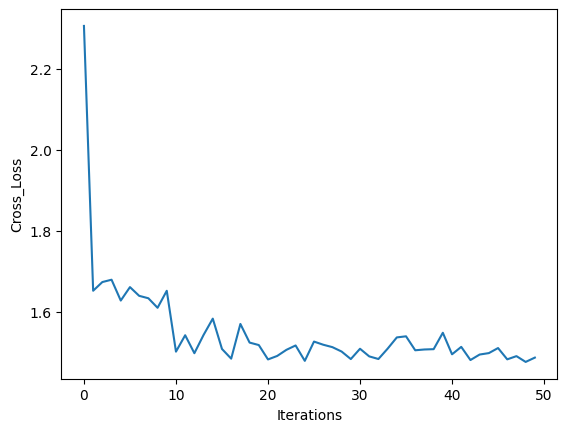

In [25]:
model_cross = MNIST()
losses_cross = train(model_cross)

In [26]:
def evaluation(model, datasets):
    model.eval()

    acc_set = list()
    for batch_id, data in enumerate(datasets()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        pred = model(images)   # 获取预测值
        acc = paddle.metric.accuracy(input=pred, label=labels)
        acc_set.extend(acc.numpy())
    
    # #计算多个batch的准确率
    acc_val_mean = np.array(acc_set).mean()
    return acc_val_mean

In [28]:
acc_of_Cross = evaluation(model_cross, test_loader)
print(acc_of_Cross)

0.96715766
